In [27]:
import torch
import gpytorch
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel, ScaleKernel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from itertools import chain
import numpy as np
import os
from torcheval.metrics import R2Score
import si_units as si
from datetime import datetime
import re

In [98]:
def is_number(s):
    try:
        float(s)
        return True
    except:
        return False
    
def is_bin_column(col) -> bool:
    """
    True für:
      - 'bin_0', 'bin_1', ... (beliebige nichtnegative Integer)
      - auch für numerische Spaltennamen wie 0, 1, '0', '1' (optional nützlich)
    """
    # numerische Spaltennamen zulassen (z. B. 0, 1, 2)
    if isinstance(col, (int, np.integer)):
        return True

    s = str(col)
    if s.isdigit():                 # '0', '1', ...
        return True
    if re.fullmatch(r"bin_\d+", s): # 'bin_0', 'bin_1', ...
        return True
    return False

all_r2 = []
all_mae = []

# Setting
normalize_feature = True
normalize_labels = True

training_iter = 100
N_A = 6.02214076e23

# CSV
csv_main = '/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/DFT_Data_clean_06_10.csv'
csv_supp = '/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP/Vext_allTEMP_noexp_rangelinBin_10.1_-15_100Bins.csv'

dft = pd.read_csv(csv_main)
Vext = pd.read_csv(csv_supp)

# Merger
dft_Vext = pd.merge(dft, Vext, on=["structure_name", "temperature_kelvin"], how="inner")

feature_columns = [col for col in dft_Vext.columns if is_bin_column(col)]
n_bins = len(feature_columns)

# Features hinzufügen
additional_features = None #["fraction_of_used_points", "volume"]
#feature_columns += additional_features

# Daten Filter ---> Vorbereitung für GP
dft_Vext = dft_Vext[dft_Vext.beladung_mol_per_kg > 0]
df_filtered = dft_Vext[dft_Vext["pressure_bar"].isin([0.1])]
df_filtered_filtered = df_filtered[df_filtered["temperature_kelvin"] == 400]
#df_filtered_filtered = df_filtered[df_filtered["temperature_kelvin"].isin([298, 300, 350, 400, 450, 500])]

# Daten für den Logger
pressure = df_filtered_filtered.get("pressure_bar", pd.Series([None])).iloc[0]
temperature = df_filtered_filtered.get("temperature_kelvin", pd.Series([None])).iloc[0]
#dp = df_filtered_filtered.get("dp_bar", pd.Series([None])).iloc[0] if "dp_bar" in df_filtered_filtered.columns else None

df_filtered_filtered.head()

,structure_name,pressure_bar,temperature_kelvin,volume_kubAng,grid.dv,density_Atmos_per_kubAng,density_bulk,fraction_of_used_points,beladung_mol_per_kg,beladung_atoms,...,bin_92,bin_93,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99,x_max,x_min
8,EON,0.1,400.0,3563.018109,0.013592,9.001273,0.000002,0.100189,0.033937,0.122344,...,224,144,192,136,136,136,136,232920,10.1,-15.0
46,OKO,0.1,400.0,3884.589614,0.014819,6.396076,0.000002,0.120880,0.023198,0.094780,...,112,104,96,144,144,232,208,227280,10.1,-15.0
84,MWW,0.1,400.0,4518.749756,0.017238,7.448088,0.000002,0.146805,0.029678,0.128388,...,184,100,144,176,196,172,160,220348,10.1,-15.0
122,SFS,0.1,400.0,3367.496936,0.012846,5.940400,0.000002,0.134964,0.022680,0.076310,...,176,132,196,124,176,124,100,223704,10.1,-15.0
160,DDR,0.1,400.0,6715.860313,0.025619,28.715224,0.000002,0.082912,0.098741,0.735655,...,143,146,149,142,96,68,109,237983,10.1,-15.0


In [99]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Hyperparameter
hps = {
    'likelihood.noise_covar.noise': torch.tensor(1e-2),
    'mean_module.constant': torch.tensor(0.0),
    'covar_module.base_kernel.lengthscale': torch.tensor(0.5),
    'covar_module.outputscale': torch.tensor(1.0),
}

In [100]:
n_total = len(df_filtered_filtered)
kf = KFold(n_splits=10, shuffle=True, random_state=42) # NICHT ÄNDERN - Vergleichbarkeit
n_splits =10
random_state=42

X = df_filtered_filtered[feature_columns].multiply(df_filtered_filtered["grid.dv"], axis=0).div(df_filtered_filtered["volume_kubAng"], axis=0)
y = df_filtered_filtered["beladung_atoms"].div(df_filtered_filtered["volume_kubAng"], axis=0)
ids = df_filtered_filtered.index.values

split_info = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    #x_train = torch.tensor(X[train_idx], dtype=torch.float32)
    #y_train = torch.tensor(y[train_idx], dtype=torch.float32)
    #x_test = torch.tensor(X[test_idx], dtype=torch.float32)
    #y_test = torch.tensor(y[test_idx], dtype=torch.float32)

    x_train = torch.tensor(X.iloc[train_idx].values, dtype=torch.float32)
    y_train = torch.tensor(y.iloc[train_idx].values, dtype=torch.float32)
    x_test  = torch.tensor(X.iloc[test_idx].values,  dtype=torch.float32)
    y_test  = torch.tensor(y.iloc[test_idx].values,  dtype=torch.float32)


    train_ids = ids[train_idx]
    test_ids = ids[test_idx]

    # Feature-Normalisierung
    if normalize_feature:
        feature_transformer = MinMaxScaler()
        feature_transformer.fit(x_train)
        xt_train = torch.tensor(feature_transformer.transform(x_train), dtype=torch.float32)
        xt_test = torch.tensor(feature_transformer.transform(x_test), dtype=torch.float32) #*2
    else:
        xt_train = x_train
        xt_test = x_test

    # Label-Normalisierung
    if normalize_labels:
        label_transformer = MinMaxScaler()  # oder StandardScaler()
        label_transformer.fit(y_train.unsqueeze(1))
        yt_train = torch.tensor(label_transformer.transform(y_train.unsqueeze(1)).flatten(), dtype=torch.float32)
        yt_test = torch.tensor(label_transformer.transform(y_test.unsqueeze(1)).flatten(), dtype=torch.float32)
    else:
        yt_train = y_train
        yt_test = y_test

    #print(xt_test.shape, yt_test.shape)
    #print(xt_train.shape, yt_train.shape)
    # Modell initialisieren
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(xt_train, yt_train, likelihood)
    model.initialize(**hps)

    optimizer = torch.optim.AdamW(
        chain(model.likelihood.parameters(), model.covar_module.parameters()),
        lr=1e-2
    )
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training
    model.train()
    likelihood.train()
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(xt_train)
        loss = -mll(output, yt_train)
        #print(loss)
        loss.backward()
        optimizer.step()


    # Vorhersage und Evaluation
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        f_preds = model(xt_test)
        ft_mean = f_preds.mean
        ft_var = f_preds.variance

        if normalize_labels:
            f_mean = torch.tensor(label_transformer.inverse_transform(ft_mean[:, None]).flatten(), dtype=torch.float32)
        else:
            f_mean = ft_mean

        mae = torch.mean(torch.abs(y_test - f_mean)).item()
        r2 = R2Score()
        r2.update(f_mean, y_test)
        r2_value = r2.compute().item()
        print("R2", r2_value)
        print("MAE", mae)

    all_mae.append(mae)
    all_r2.append(r2_value)




R2 0.11779612302780151
MAE 8.095787052297965e-06
R2 0.915215015411377
MAE 2.28903900278965e-06
R2 0.8401069045066833
MAE 4.21891809310182e-06
R2 0.9143603444099426
MAE 2.088018618451315e-06
R2 0.9693820476531982
MAE 2.2494821223517647e-06
R2 0.5258613228797913
MAE 9.750945537234657e-06
R2 -0.1995488405227661
MAE 1.5751687897136435e-05
R2 0.5561240911483765
MAE 7.833524250600021e-06
R2 0.836214005947113
MAE 5.09623896505218e-06
R2 -0.1464625597000122
MAE 1.1258052836637944e-05


In [73]:
train_mask = (
    (df_filtered_filtered["structure_name"].isin(["EON", "MWW", "OKO"])) &
    (df_filtered_filtered["pressure_bar"]==0.1) &
    (df_filtered_filtered["temperature_kelvin"] == 400)
)

test_mask = (
    (df_filtered_filtered["structure_name"].isin(["EON", "MWW", "OKO"])) &
    (df_filtered_filtered["pressure_bar"] == 0.1) &
    (df_filtered_filtered["temperature_kelvin"] == 400)
)

# DataFrames aufteilen
train_df = df_filtered_filtered[train_mask]
test_df = df_filtered_filtered[test_mask]

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 3
Test size: 3


In [87]:
ngrid = 64**3
test_df["voxel_doppel_vol"] = (test_df["volume_kubAng"] * 2 )/ ngrid

test_df["doppel_vol"] = test_df["volume_kubAng"] * 2

test_df.head()

/var/folders/p_/gl5tyfs92yg7lps1mzt8whdc0000gn/T/ipykernel_93500/2810183909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["voxel_doppel_vol"] = (test_df["volume_kubAng"] * 2 )/ ngrid
/var/folders/p_/gl5tyfs92yg7lps1mzt8whdc0000gn/T/ipykernel_93500/2810183909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["doppel_vol"] = test_df["volume_kubAng"] * 2


,structure_name,pressure_bar,temperature_kelvin,volume_kubAng,grid.dv,density_Atmos_per_kubAng,density_bulk,fraction_of_used_points,beladung_mol_per_kg,beladung_atoms,...,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99,x_min,x_max,voxel_doppel_vol,doppel_vol
8,EON,0.1,400.0,3563.018109,0.013592,9.001273,0.000002,0.100189,0.033937,0.122344,...,0,0,8,0,0,8,7104.573665,0.000045,0.027184,7126.036219
46,OKO,0.1,400.0,3884.589614,0.014819,6.396076,0.000002,0.120880,0.023198,0.094780,...,0,0,8,0,0,8,1125.471241,0.000045,0.029637,7769.179228
84,MWW,0.1,400.0,4518.749756,0.017238,7.448088,0.000002,0.146805,0.029678,0.128388,...,32,20,32,32,24,36,974.248749,0.000045,0.034475,9037.499512


In [88]:


X_train = train_df[feature_columns].multiply(train_df["grid.dv"], axis=0).div(train_df["volume_kubAng"], axis=0)
y_train = train_df["beladung_atoms"].div(train_df["volume_kubAng"], axis=0)
X_test = test_df[feature_columns].multiply(test_df["voxel_doppel_vol"], axis=0).div(test_df["doppel_vol"], axis=0)
y_test = test_df["beladung_atoms"].div(test_df["doppel_vol"], axis=0) * 2

X_train_np = X_train.to_numpy(dtype=np.float64)
y_train_np = y_train.to_numpy(dtype=np.float64)
X_test_np  = X_test.to_numpy(dtype=np.float64)
y_test_np  = y_test.to_numpy(dtype=np.float64)

x_train = torch.from_numpy(X_train_np)
y_train = torch.from_numpy(y_train_np)
x_test  = torch.from_numpy(X_test_np)
y_test  = torch.from_numpy(y_test_np)

# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [91]:

# Torch Tensors
#x_train = torch.tensor(X_train, dtype=torch.float64)
#y_train = torch.tensor(y_train, dtype=torch.float64)
#x_test = torch.tensor(X_test, dtype=torch.float64)
#y_test = torch.tensor(y_test, dtype=torch.float64)


    # Feature-Normalisierung
if normalize_feature:
        feature_transformer = MinMaxScaler()
        feature_transformer.fit(x_train)
        xt_train = torch.tensor(feature_transformer.transform(x_train), dtype=torch.float32)
        xt_test = torch.tensor(feature_transformer.transform(x_test), dtype=torch.float32)
else:
        xt_train = x_train
        xt_test = x_test

    # Label-Normalisierung
if normalize_labels:
        label_transformer = MinMaxScaler()  # oder StandardScaler()
        label_transformer.fit(y_train.unsqueeze(1))
        yt_train = torch.tensor(label_transformer.transform(y_train.unsqueeze(1)).flatten(), dtype=torch.float32)
        yt_test = torch.tensor(label_transformer.transform(y_test.unsqueeze(1)).flatten(), dtype=torch.float32)
else:
        yt_train = y_train
        yt_test = y_test

    
    # Modell initialisieren
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(xt_train, yt_train, likelihood)
model.initialize(**hps)

optimizer = torch.optim.AdamW(
        chain(model.likelihood.parameters(), model.covar_module.parameters()),
        lr=1e-2
    )
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training
model.train()
likelihood.train()
for i in range(training_iter):
        optimizer.zero_grad()
        output = model(xt_train)
        loss = -mll(output, yt_train)
        loss.backward()
        optimizer.step()

    # Vorhersage und Evaluation
model.eval()
likelihood.eval()
with torch.no_grad():
        f_preds = model(xt_test)
        ft_mean = f_preds.mean

        if normalize_labels:
            f_mean = torch.tensor(label_transformer.inverse_transform(ft_mean[:, None]).flatten(), dtype=torch.float32)
        else:
            f_mean = ft_mean

        mae = torch.mean(torch.abs(y_test - f_mean)).item()
        r2 = R2Score()
        r2.update(f_mean, y_test)
        r2_value = r2.compute().item()
        print("R2", r2_value)
        print("MAE", mae)

all_mae.append(mae)
all_r2.append(r2_value)


R2 0.9998283982276917
MAE 4.020205426265739e-08


y_true: [2.43990944e-05 1.62844190e-05 3.25690598e-05 2.20335205e-05
 1.53088422e-05 2.72553916e-05 1.06276821e-05 6.19888160e-05
 3.03736961e-05 2.24103933e-05 2.33015708e-05 4.75345114e-05
 8.36946693e-11 2.20077600e-05 2.53481558e-05 1.18004637e-05
 1.28306547e-05 1.94131557e-04 7.18754964e-05 1.18594535e-05
 1.96316432e-05 2.34430718e-05 1.85321715e-05 3.14720783e-05]
y_pred: [2.3396311e-05 1.8114501e-05 2.7256621e-05 2.3433533e-05 1.3970513e-05
 2.5158550e-05 9.0993099e-06 5.9183800e-05 2.9063842e-05 1.9517423e-05
 2.3708295e-05 4.3174587e-05 5.1341857e-07 1.9290625e-05 1.0618101e-05
 1.0337502e-05 1.2541546e-05 2.1399433e-06 4.4035554e-05 1.1660182e-05
 1.9854908e-05 2.0550444e-05 1.8790735e-05 3.2264110e-05]


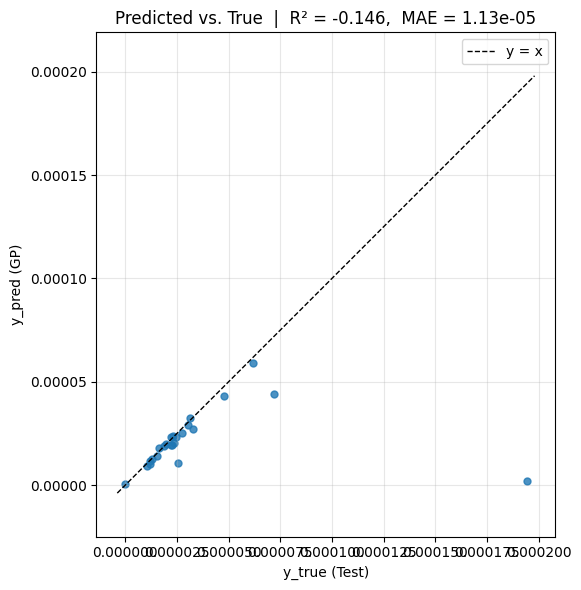

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# ---- y_true / y_pred aus Torch -> NumPy ----
y_true = y_test.detach().cpu().numpy()
y_pred = f_mean.detach().cpu().numpy()

print("y_true:", y_true)
print("y_pred:", y_pred)
# R² ggf. neu berechnen (oder r2_value verwenden)
from sklearn.metrics import r2_score, mean_absolute_error
r2_here = r2_score(y_true, y_pred)
mae_here = mean_absolute_error(y_true, y_pred)

# ---- 1:1-Referenzlinie bestimmen ----
lo = min(np.min(y_true), np.min(y_pred))
hi = max(np.max(y_true), np.max(y_pred))
pad = 0.02 * (hi - lo if hi > lo else 1.0)
xline = np.linspace(lo - pad, hi + pad, 100)

# ---- Plot ----
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=25, alpha=0.8)
plt.plot(xline, xline, 'k--', linewidth=1, label="y = x")

plt.xlabel("y_true (Test)")
plt.ylabel("y_pred (GP)")
plt.title(f"Predicted vs. True  |  R² = {r2_here:.3f},  MAE = {mae_here:.3g}")
plt.grid(True, alpha=0.3)
plt.axis('equal')  # optional: gleiche Skalierung auf beiden Achsen
plt.legend()
plt.tight_layout()
plt.show()
